<a href="https://colab.research.google.com/github/vsham05/Detection-OCR-HandwritingModel/blob/main/%D0%9F%D0%B5%D1%80%D0%B2%D1%8B%D0%B9%D0%91%D0%98%D0%A2_%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Краткая информация**

В данном ноутбуке представлены основные способы обнаружения и распознания рукописного текста на изображении для дальнейшей оцифровки текстов.

Работа выполнена в рамках прохождения практики в компании Первый Бит.

# **Датасеты**

Для создания модели используются датасеты с открытых источников.



*   [Будет добавлено позже](https://)
*   Новый пункт



# **Создание модели детекции рукописного текста**

In [ ]:
!unzip /content/drive/MyDrive/Датасет_на_практику/Russian_Handwritten_Text.v7i.coco.zip

Archive:  /content/drive/MyDrive/Датасет_на_практику/Russian_Handwritten_Text.v7i.coco.zip
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

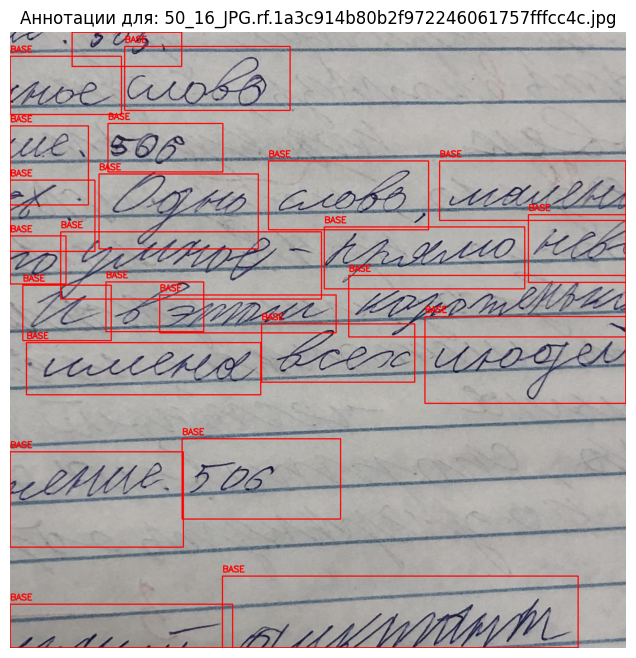

In [ ]:
import json
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def visualize_annotations_for_image(image_path, annotation_path):
    """
    Визуализирует все аннотации (bounding boxes + сегментации) для одной картинки.

    Args:
        image_path (str): Путь к изображению (например, "train/image1.jpg").
        annotation_path (str): Путь к `_annotations.coco.json`.
    """
    # Загружаем аннотации
    with open(annotation_path, 'r') as f:
        coco_data = json.load(f)

    # Находим имя файла (например, "image1.jpg")
    image_filename = os.path.basename(image_path)


    # Ищем информацию о картинке в аннотациях
    image_info = None
    for img in coco_data["images"]:
        if img["file_name"] == image_filename:
            image_info = img
            break

    if not image_info:
        print(f"❌ Изображение {image_filename} не найдено в аннотациях!")
        return

    # Загружаем само изображение
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR → RGB

    # Получаем все аннотации для этой картинки
    annotations = [
        ann for ann in coco_data["annotations"]
        if ann["image_id"] == image_info["id"]
    ]

    # Отрисовываем каждую аннотацию
    for ann in annotations:
        # --- 1. Рисуем Bounding Box ---
        if "bbox" in ann:
            x, y, w, h = map(int, ann["bbox"])
            cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Синий прямоугольник

        # --- 2. Рисуем сегментацию (полигон) ---
        if "segmentation" in ann:
            for seg in ann["segmentation"]:
                points = np.array(seg, np.int32).reshape((-1, 2))
                cv2.polylines(image, [points], True, (0, 255, 0), 2)  # Зелёный контур

        # --- 3. Подписываем класс объекта ---
        if "category_id" in ann:
            category_id = ann["category_id"]
            category_name = next(
                (cat["name"] for cat in coco_data["categories"] if cat["id"] == category_id),
                str(category_id))
            cv2.putText(
                image, category_name, (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2
            )

    # Показываем результат
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Аннотации для: {image_filename}")
    plt.show()

# Пример использования:
image_path = "/content/test/50_16_JPG.rf.1a3c914b80b2f972246061757fffcc4c.jpg"  # Путь к конкретной картинке
annotation_path = "/content/test/_annotations.coco.json"  # Путь к аннотациям

if os.path.exists(image_path) and os.path.exists(annotation_path):
    visualize_annotations_for_image(image_path, annotation_path)
else:
    print("❌ Файл не найден!")

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt




def resize_square(image, size):
    return cv2.resize(image, (size, size))


def upscale_blue(image_path):
    # Load image
    im = cv2.imread(image_path)

    # Define lower and upper limits of our blue
    BlueMin = np.array([100, 50, 20], np.uint8)    # более темные оттенки
    BlueMax = np.array([120, 255, 255], np.uint8)

    # Go to HSV colourspace and get mask of blue pixels
    HSV  = cv2.cvtColor(im,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(HSV, BlueMin, BlueMax)

    # Make all pixels in mask white
    im[mask>0] = [255,255,255]
    return im

def binarize_image(image_path=None, is_image=False, image=None):
    if not is_image:
        im = cv2.imread('/content/test/81_8_JPG.rf.fb0b35158c883e7a68ecbd2ba3a6360c.jpg')
        _, binary_image = cv2.threshold(im, 127, 255, cv2.THRESH_OTSU)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return binary_image

def preproccess_data(folder_path):

# Получаем список файлов
    images = [folder_path + '/' + e for e in os.listdir(folder_path) if e.endswith('.jpg')]
    res = images
    for image in images:
        new_image = binarize_image(image)
        res.append(new_image)






In [ ]:
import torch
from torch.utils.data import Dataset
import json
import cv2
import os

class CocoDetectionDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)

        self.image_ids = [img['id'] for img in self.coco_data['images']]
        self.id_to_img = {img['id']: img for img in self.coco_data['images']}
        self.id_to_anns = {img_id: [] for img_id in self.image_ids}

        for ann in self.coco_data['annotations']:
            self.id_to_anns[ann['image_id']].append(ann)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.id_to_img[img_id]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = resize_square(image, 400)

        #------------------- Предобработка ------------------

        image = binarize_image(is_image=True, image=image)

        valid_bboxes = []

        #----------------------------------------------------

        anns = self.id_to_anns[img_id]
        boxes = []
        labels = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            roi = image[round(y):round(y)+round(h), round(x):round(x)+round(w)]

            if np.sum(roi < 100) > 5:
                boxes.append([x, y, x + w, y + h])  # COCO: [x,y,w,h] → [x1,y1,x2,y2]
                labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([img_id])
        }

        if self.transform:
            transformed = self.transform(image=image, bboxes=target['boxes'], labels=target['labels'])
            image = transformed['image']
            target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
            target['labels'] = torch.as_tensor(transformed['labels'], dtype=torch.int64)

        image = (torch.from_numpy(image).permute(1, 0).float() / 255.0).unsqueeze(0)
        return image, target

In [ ]:
import os, os.path
# simple version for working with CWD
print(len([name for name in os.listdir('.') if os.path.isfile(name)]))
# path joining version for other paths
DIR = '/content/train'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

2
2479


In [ ]:

from torch.utils.data import DataLoader

# Пути к данным
train_dir = "/content/train"
train_annotations = os.path.join(train_dir, "_annotations.coco.json")

# Создаем датасет
dataset = CocoDetectionDataset(
    root_dir=train_dir,
    annotation_file=train_annotations,
    transform=None,  # Можно добавить аугментации (Albumentations)
)

val_dir = "/content/valid"
val_annotations = os.path.join(val_dir, "_annotations.coco.json")


val_dataset = CocoDetectionDataset(
    root_dir=val_dir,
    annotation_file=val_annotations,
    transform=None,  # Можно добавить аугментации (Albumentations)
)

# Пример загрузки одной картинки
image, target = dataset[0]
print("Image shape:", image.shape)
print("Bounding boxes:", target['boxes'])
print("Labels:", target['labels'])
print(len(dataset))

Image shape: torch.Size([1, 400, 400])
Bounding boxes: tensor([[126.0000,   0.0000, 479.3610,  31.0000],
        [  0.0000, 122.0000, 192.5800, 171.0000],
        [  0.0000, 351.0000, 165.9160, 483.0000],
        [205.0000, 343.0000, 561.7090, 446.0400],
        [  0.0000,  93.0000,  93.9180, 138.0000],
        [ 62.0000,  60.0000, 186.3050, 104.2300],
        [106.0000,  97.0000, 166.8210, 128.8500],
        [377.0000, 107.0000, 528.8880, 261.5400]])
Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1])
2478


In [ ]:

dataloader = DataLoader(
    dataset,
    batch_size=9,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))  # Для поддержки разного числа объектов в изображениях
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=3,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))  # Для поддержки разного числа объектов в изображениях
)


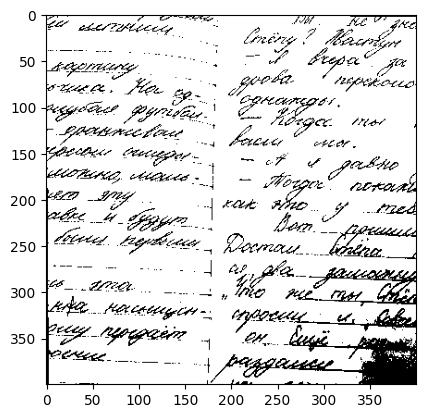

torch.Size([400, 400, 1])


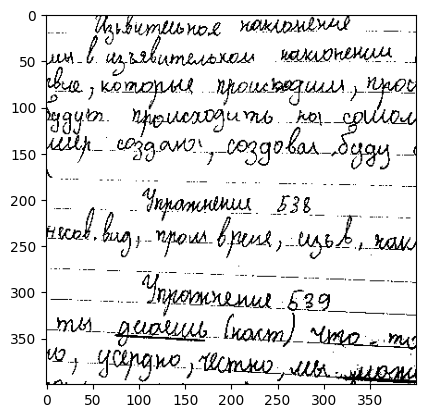

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

image = np.transpose(image)

mask = dataset[1][0]
mask = np.transpose(mask)
plt.imshow(mask, cmap='gray')
plt.show()

another = val_dataset[1][0]
another = np.transpose(another)
print(another.size())
plt.imshow(another, cmap='gray')
plt.show()

In [ ]:
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torch import nn

class SwinBackboneWithFPN(nn.Module):
    def __init__(self):
        super().__init__()
        self.swin = swin_transformer.SwinTransformer(
            img_size=400,
            patch_size=4,
            embed_dim=128,
            depths=[2, 2, 18, 2],
            num_heads=[4, 8, 16, 32],
            window_size=7
        )
        # Указываем выходные слои для FPN
        self.return_layers = {'layers.0': '0', 'layers.1': '1', 'layers.2': '2', 'layers.3': '3'}
        self.out_channels = 128  # Должно соответствовать embed_dim Swin

    def forward(self, x):
        features = self.swin(x)
        return features

In [ ]:
import torch
import torch.optim as optim
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.detection import fasterrcnn_resnet50_fpn, fcos_resnet50_fpn
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from tqdm import tqdm

# Инициализация TensorBoard
writer = SummaryWriter('/content/runs')

# Загрузка модели
fcos_model = fcos_resnet50_fpn(num_classes=2)



model = fasterrcnn_resnet50_fpn(pretrained = False, pretrained_backbone = False)
for head in [model.roi_heads.box_predictor.cls_score, model.roi_heads.box_predictor.bbox_pred]:
    # Заменяем Sequential на новый с Dropout
    head.__dict__['_modules']['0'] = nn.Sequential(
        nn.Dropout(p=0.6),  # 50% dropout
    )
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features,
    num_classes=2  # Новое число классов
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
fcos_model = fcos_model.to(device)

# Заморозка части слоёв
for name, param in model.backbone.body.named_parameters():
    if "layer1" in name or "layer2" in name or "layer3" in name:
        param.requires_grad = False

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Датасеты и DataLoader'ы

def collate_fn(batch):
    return tuple(zip(*batch))




# Параметры ранней остановки


def train(model):
    patience = 7  # Количество эпох без улучшения перед остановкой
    min_delta = 0.01  # Минимальное изменение для учёта улучшения
    best_val_loss = np.inf
    epochs_no_improve = 0
    early_stop = False


    # Обучение с валидацией
    num_epochs = 50

    for epoch in range(num_epochs):
        if early_stop:
            print(f"Early stopping triggered after {epoch} epochs!")
            break
        # Режим обучения
        model.train()
        train_loss = 0.0

        # Прогресс-бар для обучения
        train_iter = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, targets in train_iter:
            if any(len(t["boxes"]) == 0 for t in targets):
                continue

            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()

            train_loss += losses.item()
            train_iter.set_postfix(loss=losses.item())

        # Режим валидации
        model.eval()
        val_loss = 0.0
        val_iter = tqdm(val_dataloader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

        with torch.no_grad():
            for images, targets in val_iter:
                if any(len(t["boxes"]) == 0 for t in targets):
                    continue

                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # В режиме eval модель возвращает детекции, а не loss
                detections = model(images)

                # Инициализируем batch_loss перед использованием
                batch_loss = 0.0

                for det, gt in zip(detections, targets):
                    if len(det["boxes"]) == 0 or len(gt["boxes"]) == 0:
                        continue

                    # Пример: MSE между предсказанными и истинными bounding boxes
                    ious = torchvision.ops.box_iou(det["boxes"], gt["boxes"])
                    best_iou, _ = ious.max(dim=1)
                    batch_loss += (1.0 - best_iou).mean()  # Чем хуже IoU, тем больше loss

                # Теперь batch_loss доступна здесь
                try:
                    val_loss += batch_loss.item()
                    val_iter.set_postfix(loss=batch_loss.item())
                except:
                    val_loss += batch_loss
                    val_iter.set_postfix(loss=batch_loss)

        # Вычисление средних лоссов
        avg_train_loss = train_loss / len(dataloader)
        avg_val_loss = val_loss / len(val_dataloader)

        # Логирование
        writer.add_scalar('Loss/train', avg_train_loss, epoch)
        writer.add_scalar('Loss/val', avg_val_loss, epoch)

        # Проверка на улучшение val_loss
        if avg_val_loss < best_val_loss - min_delta:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'New best model saved with val loss: {best_val_loss:.4f}')
        else:
            epochs_no_improve += 1
            print(f'No improvement for {epochs_no_improve}/{patience} epochs')

            if epochs_no_improve >= patience:
                early_stop = True

        # Сохранение лучшей модели
        if avg_val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_model.pth')
            best_val_loss = avg_val_loss
            print(f'New best model saved with val loss: {best_val_loss:.4f}')

        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')
        print('-' * 50)
    writer.close()
    return model



model = train(model)
#fcos_model = train(fcos_model)










Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py

New best model saved with val loss: 1.6452

Epoch 1/50
Train Loss: 0.7786 | Val Loss: 1.6452
--------------------------------------------------


Epoch 2/50 [Val]: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s, loss=2.38]


New best model saved with val loss: 1.2254

Epoch 2/50
Train Loss: 0.5076 | Val Loss: 1.2254
--------------------------------------------------


Epoch 3/50 [Val]: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s, loss=2.39]


New best model saved with val loss: 1.2053

Epoch 3/50
Train Loss: 0.5068 | Val Loss: 1.2053
--------------------------------------------------


Epoch 4/50 [Val]: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s, loss=2.36]


No improvement for 1/7 epochs

Epoch 4/50
Train Loss: 0.5224 | Val Loss: 1.2260
--------------------------------------------------


Epoch 5/50 [Val]: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s, loss=2.55]


No improvement for 2/7 epochs

Epoch 5/50
Train Loss: 0.5264 | Val Loss: 1.2337
--------------------------------------------------


Epoch 6/50 [Val]: 100%|██████████| 6/6 [00:01<00:00,  5.23it/s, loss=1.57]


No improvement for 3/7 epochs

Epoch 6/50
Train Loss: 0.5274 | Val Loss: 1.5031
--------------------------------------------------


Epoch 7/50 [Train]:   5%|▍         | 13/276 [00:22<05:48,  1.32s/it, loss=0.804]

In [ ]:
torch.save(model.state_dict(),  '/content/drive/MyDrive/hocr_ru_detection_weights/wights.hp')

[{'boxes': tensor([[0.0000e+00, 4.6430e+02, 5.9674e+02, 6.6189e+02],
        [0.0000e+00, 5.5801e+02, 5.9755e+02, 7.5615e+02],
        [0.0000e+00, 6.9805e+02, 5.9724e+02, 8.9667e+02],
        [0.0000e+00, 8.3826e+02, 5.9704e+02, 1.0365e+03],
        [0.0000e+00, 2.7234e+02, 5.9455e+02, 9.8483e+02],
        [1.8951e+00, 4.4387e+02, 2.9856e+02, 1.1160e+03],
        [0.0000e+00, 2.3092e+02, 5.9990e+02, 4.2846e+02],
        [1.8498e+00, 3.1227e+01, 2.9890e+02, 4.6897e+02],
        [0.0000e+00, 3.2414e+02, 5.9968e+02, 5.2240e+02],
        [0.0000e+00, 1.3698e+02, 5.9973e+02, 3.3545e+02],
        [0.0000e+00, 9.3204e+02, 6.0053e+02, 1.1303e+03],
        [0.0000e+00, 7.8869e+02, 8.2422e+02, 1.1654e+03],
        [0.0000e+00, 5.1374e+00, 5.9524e+02, 7.1966e+02],
        [0.0000e+00, 6.2827e+02, 5.0216e+02, 1.1679e+03],
        [0.0000e+00, 4.3183e+02, 8.2496e+02, 8.2434e+02],
        [0.0000e+00, 6.1053e+02, 8.2593e+02, 1.0015e+03],
        [0.0000e+00, 4.4320e+01, 6.0004e+02, 2.4206e+02],
   

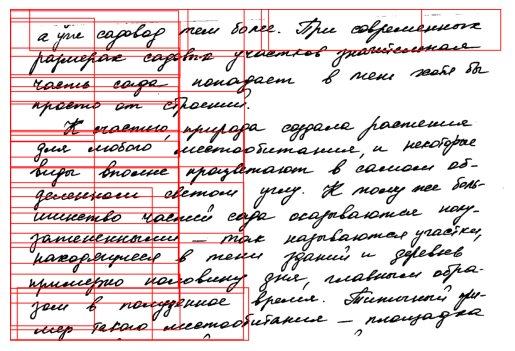

In [ ]:
from PIL import Image, ImageDraw
import torch
import torchvision
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt

# 1. Загрузка изображения через PIL
image_path = "/content/3.png"
image = Image.open(image_path).convert("RGB")  # Конвертируем в RGB

# 2. Преобразование в тензор для PyTorch
image_tensor = F.to_tensor(image).to(device)  # Автоматически нормализует в [0, 1]



with torch.no_grad():
    predictions = model([image_tensor])
print(predictions)
# 5. Визуализация
def visualize_pil(image, predictions, confidence_threshold=0.25):
    boxes = predictions[0]['boxes']
    scores = predictions[0]['scores']
    labels = predictions[0]['labels']

    keep = scores > confidence_threshold
    boxes = boxes[keep]

    # Рисуем bounding boxes
    draw = ImageDraw.Draw(image)
    for box in boxes:
        draw.rectangle(box.tolist(), outline="red", width=3)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

visualize_pil(image, predictions)

**Использование другой модели YOLO8**

Для использования модели YOLO необходим другой формат данных


In [ ]:
import json
import yaml
import os
import shutil
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split

def coco2yaml(
    coco_json_path: str,
    output_dir: str = 'yolo_dataset',
    dataset_path: str = '.',
    train_split: float = 0.8,
    val_split: float = 0.2,
    seed: int = 42,
    create_labels: bool = True,
    yaml_only: bool = False,
    copy_images: bool = True,
    img_extensions: tuple = ('.jpg', '.jpeg', '.png')
) -> str:
    """
    Полностью конвертирует COCO JSON в YOLO формат с копированием изображений.

    Параметры:
        coco_json_path: Путь к COCO annotations.json
        output_dir: Папка для результатов (по умолчанию 'yolo_dataset')
        dataset_path: Базовая папка с изображениями
        train_split: Доля тренировочных данных (0-1)
        val_split: Доля валидационных данных (0-1)
        seed: Random seed для разделения
        create_labels: Создавать TXT аннотации
        yaml_only: Только YAML без аннотаций
        copy_images: Копировать изображения в новую структуру
        img_extensions: Допустимые расширения изображений

    Возвращает:
        Путь к созданному YAML файлу
    """
    # Проверка входных данных
    assert os.path.exists(coco_json_path), f"Файл {coco_json_path} не найден"
    assert 0 < train_split < 1 and 0 < val_split < 1, "Некорректные значения split"
    os.makedirs(output_dir, exist_ok=True)

    # Загрузка COCO данных
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Получаем информацию о классах
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    nc = len(categories)

    # Создаем маппинг image_id -> image_info
    id_to_img = {img['id']: img for img in coco_data['images']}

    # Разделение на train/val
    all_images = list(id_to_img.keys())
    train_ids, val_ids = train_test_split(
        all_images,
        train_size=train_split,
        test_size=val_split,
        random_state=seed
    )

    # Создаем структуру папок
    os.makedirs(os.path.join(output_dir, 'images', 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images', 'val'), exist_ok=True)
    if create_labels and not yaml_only:
        os.makedirs(os.path.join(output_dir, 'labels', 'train'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'labels', 'val'), exist_ok=True)

    # Функция конвертации COCO bbox в YOLO формат
    def coco2yolo_bbox(bbox, img_w, img_h):
        x, y, w, h = bbox
        x_center = (x + w/2) / img_w
        y_center = (y + h/2) / img_h
        w_norm = w / img_w
        h_norm = h / img_h
        return x_center, y_center, w_norm, h_norm

    # Обработка изображений
    for img_id, split in tqdm(
        [(img_id, 'train') for img_id in train_ids] + [(img_id, 'val') for img_id in val_ids],
        desc="Обработка данных"
    ):
        img_info = id_to_img[img_id]
        img_file = img_info['file_name']
        img_w, img_h = img_info['width'], img_info['height']

        # Полные пути к файлам
        src_img_path = os.path.join(dataset_path, img_file)
        dst_img_dir = os.path.join(output_dir, 'images', split)
        dst_img_path = os.path.join(dst_img_dir, os.path.basename(img_file))

        # Копирование изображений
        if copy_images:
            try:
                shutil.copy2(src_img_path, dst_img_path)
            except FileNotFoundError:
                print(f"⚠️ Изображение не найдено: {src_img_path}")
                continue

        # Создание аннотаций
        if create_labels and not yaml_only:
            txt_filename = f"{os.path.splitext(img_file)[0]}.txt"
            txt_path = os.path.join(output_dir, 'labels', split, txt_filename)

            anns = [ann for ann in coco_data['annotations'] if ann['image_id'] == img_id]
            with open(txt_path, 'w') as f:
                for ann in anns:
                    if ann['bbox'] and ann['category_id'] in categories:
                        yolo_bbox = coco2yolo_bbox(ann['bbox'], img_w, img_h)
                        f.write(f"{ann['category_id']} {' '.join(map(str, yolo_bbox))}\n")

    # Создание YAML файла
    yaml_data = {
        'path': os.path.abspath(output_dir),
        'train': 'images/train',
        'val': 'images/val',
        'names': categories,
        'nc': nc,
    }

    yaml_path = os.path.join(output_dir, 'data.yaml')
    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_data, f, sort_keys=False, default_flow_style=False)

    print(f"\n✅ Конвертация завершена!")
    print(f"• YAML файл: {yaml_path}")
    print(f"• Изображения: {os.path.join(output_dir, 'images')}")
    if create_labels and not yaml_only:
        print(f"• Аннотации: {os.path.join(output_dir, 'labels')}")

    return yaml_path

# Пример использования
if __name__ == "__main__":
    yaml_file = coco2yaml(
        coco_json_path='/content/train/_annotations.coco.json',
        output_dir='/content/yolo_train',
        dataset_path='/content/train',
        train_split=0.8,
        val_split=0.2,
        copy_images=True
    )
    print(f"Создан YAML файл: {yaml_file}")

Обработка данных: 100%|██████████| 2478/2478 [00:44<00:00, 55.12it/s]


✅ Конвертация завершена!
• YAML файл: /content/yolo_train/data.yaml
• Изображения: /content/yolo_train/images
• Аннотации: /content/yolo_train/labels
Создан YAML файл: /content/yolo_train/data.yaml


In [ ]:
!pip install  ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
model.train(data='/content/yolo_train/data.yaml', epochs=120, imgsz=640)

Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_train/data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretr

train: Scanning /content/yolo_train/labels/train... 1982 images, 7 backgrounds, 0 corrupt: 100%|██████████| 1982/1982 [00:01<00:00, 1458.09it/s]

train: New cache created: /content/yolo_train/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1203.2±1382.4 MB/s, size: 288.2 KB)


val: Scanning /content/yolo_train/labels/val... 496 images, 2 backgrounds, 0 corrupt: 100%|██████████| 496/496 [00:01<00:00, 486.68it/s]


val: New cache created: /content/yolo_train/labels/val.cache
Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      4.89G      1.786       1.69      1.359       1198        640: 100%|██████████| 124/124 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


                   all        496      34417      0.815      0.804       0.83      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      4.92G      1.414     0.9027      1.148       1389        640: 100%|██████████| 124/124 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

                   all        496      34417      0.832      0.817      0.884      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      4.93G      1.343     0.8385      1.112       1339        640: 100%|██████████| 124/124 [00:55<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


                   all        496      34417      0.869       0.81      0.892      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      4.95G      1.315     0.8165      1.102       1237        640: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        496      34417      0.882      0.842      0.913      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      4.97G      1.283     0.7883      1.087        968        640: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


                   all        496      34417      0.878       0.85      0.914      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      4.98G      1.266     0.7675      1.077       1023        640: 100%|██████████| 124/124 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


                   all        496      34417      0.907      0.855      0.927      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120         5G      1.258     0.7508      1.077       1149        640: 100%|██████████| 124/124 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


                   all        496      34417      0.899      0.866      0.929      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120      5.02G      1.245      0.735      1.066       1633        640: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]


                   all        496      34417      0.901       0.85      0.923      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120      5.04G      1.238      0.726      1.064       1526        640: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


                   all        496      34417      0.907       0.87      0.936      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      5.05G      1.218     0.7185      1.055       1285        640: 100%|██████████| 124/124 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]


                   all        496      34417       0.91      0.857       0.93      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      5.07G      1.212     0.7041      1.053       1180        640: 100%|██████████| 124/124 [00:52<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


                   all        496      34417      0.905      0.856      0.933      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      5.09G      1.202     0.6978       1.05       1321        640: 100%|██████████| 124/124 [00:52<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        496      34417      0.913      0.862      0.936      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120       5.1G      1.184     0.6862      1.042       1278        640: 100%|██████████| 124/124 [00:52<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


                   all        496      34417       0.91      0.872      0.937      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      5.12G      1.185     0.6841      1.044       1380        640: 100%|██████████| 124/124 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]


                   all        496      34417      0.916      0.878      0.943      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120      5.14G      1.187     0.6764      1.042        966        640: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


                   all        496      34417      0.918      0.872      0.941      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      5.16G      1.168     0.6739      1.037       1007        640: 100%|██████████| 124/124 [00:49<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        496      34417      0.917      0.874      0.944      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      5.17G      1.166     0.6677      1.036       1338        640: 100%|██████████| 124/124 [00:52<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]


                   all        496      34417      0.917      0.885      0.943      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      5.19G      1.154     0.6604      1.031       1149        640: 100%|██████████| 124/124 [00:52<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


                   all        496      34417      0.914      0.877      0.943      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      5.21G      1.155     0.6592      1.032       1118        640: 100%|██████████| 124/124 [00:52<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


                   all        496      34417      0.919      0.871      0.943      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      5.22G      1.157     0.6555      1.028       1308        640: 100%|██████████| 124/124 [00:52<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]


                   all        496      34417      0.913      0.877      0.947      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      5.24G      1.141     0.6431      1.023       1235        640: 100%|██████████| 124/124 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


                   all        496      34417      0.925      0.894      0.954      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      5.26G      1.128     0.6355      1.019       1459        640: 100%|██████████| 124/124 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]


                   all        496      34417      0.911      0.879      0.946      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      5.28G      1.133     0.6401      1.021        952        640: 100%|██████████| 124/124 [00:53<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


                   all        496      34417      0.923       0.88      0.949       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      5.29G      1.128      0.638      1.018       1182        640: 100%|██████████| 124/124 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


                   all        496      34417      0.919      0.893      0.954      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      5.31G      1.129     0.6346      1.018       1306        640: 100%|██████████| 124/124 [00:52<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


                   all        496      34417      0.927       0.89      0.952      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      5.33G      1.123     0.6284      1.015       1169        640: 100%|██████████| 124/124 [00:55<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


                   all        496      34417      0.919      0.882       0.95      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      5.34G      1.121     0.6326      1.018       1220        640: 100%|██████████| 124/124 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]


                   all        496      34417      0.918      0.887      0.948      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120      5.36G      1.115     0.6256      1.014       1306        640: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

                   all        496      34417      0.919      0.883      0.951      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      5.38G      1.111     0.6196      1.012       1098        640: 100%|██████████| 124/124 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]

                   all        496      34417       0.92      0.884      0.951      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      5.39G      1.113     0.6219      1.013       1379        640: 100%|██████████| 124/124 [00:52<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


                   all        496      34417      0.922      0.888      0.952      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      5.41G      1.096     0.6119      1.006       1126        640: 100%|██████████| 124/124 [00:52<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


                   all        496      34417       0.93      0.896      0.956      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120      5.43G      1.107     0.6161      1.007       1167        640: 100%|██████████| 124/124 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


                   all        496      34417      0.929      0.898      0.956      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      5.45G      1.102     0.6117      1.006       1333        640: 100%|██████████| 124/124 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.60it/s]


                   all        496      34417      0.931      0.895      0.957      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      5.46G      1.095     0.6077      1.004       1518        640: 100%|██████████| 124/124 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


                   all        496      34417      0.921      0.892      0.954      0.688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      5.48G      1.095     0.6052      1.004       1337        640: 100%|██████████| 124/124 [00:56<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


                   all        496      34417      0.921      0.895      0.955      0.692

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120       5.5G      1.093     0.6021      1.002       1221        640: 100%|██████████| 124/124 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


                   all        496      34417      0.932      0.892      0.956      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      5.51G      1.087     0.5997      1.001       1308        640: 100%|██████████| 124/124 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]


                   all        496      34417      0.917      0.896      0.955      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      5.53G      1.081     0.5989     0.9996       1762        640: 100%|██████████| 124/124 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


                   all        496      34417      0.925      0.895      0.955      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      5.55G      1.082     0.5975     0.9988       1421        640: 100%|██████████| 124/124 [00:55<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        496      34417      0.933      0.894      0.958      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      5.57G      1.076     0.5927     0.9961       1467        640: 100%|██████████| 124/124 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


                   all        496      34417      0.922      0.898      0.956      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      5.58G      1.069     0.5892     0.9918       1505        640: 100%|██████████| 124/124 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


                   all        496      34417      0.931      0.893      0.957      0.698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120       5.6G      1.081     0.5962     0.9984       1607        640: 100%|██████████| 124/124 [00:53<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


                   all        496      34417      0.928      0.898      0.959      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      5.62G      1.057     0.5843     0.9895       1450        640: 100%|██████████| 124/124 [00:52<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.74it/s]


                   all        496      34417      0.932      0.903       0.96      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      5.63G      1.074       0.59     0.9945       1354        640: 100%|██████████| 124/124 [00:55<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


                   all        496      34417      0.931      0.905      0.962      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      5.65G      1.059     0.5829     0.9919       1124        640: 100%|██████████| 124/124 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


                   all        496      34417      0.928      0.899      0.959      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      5.67G      1.064     0.5829      0.991       1002        640: 100%|██████████| 124/124 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


                   all        496      34417      0.934        0.9      0.961      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      5.69G      1.057     0.5788     0.9882       1358        640: 100%|██████████| 124/124 [00:53<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


                   all        496      34417      0.936      0.906      0.963      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120       5.7G      1.061     0.5801     0.9911       1250        640: 100%|██████████| 124/124 [00:54<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        496      34417      0.937      0.901      0.961      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      5.72G      1.061     0.5814     0.9909       1105        640: 100%|██████████| 124/124 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]


                   all        496      34417       0.93      0.906      0.962      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      5.74G      1.051     0.5771     0.9899       1044        640: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


                   all        496      34417      0.928      0.906      0.961      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      5.75G      1.051     0.5747     0.9876       1222        640: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

                   all        496      34417      0.931      0.909      0.963      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      5.77G      1.046     0.5683     0.9814       1297        640: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]


                   all        496      34417      0.938      0.906      0.963      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      5.79G      1.045     0.5675     0.9843       1516        640: 100%|██████████| 124/124 [00:53<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]


                   all        496      34417      0.939      0.912      0.965      0.711

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120       5.8G      1.045     0.5681     0.9828       1499        640: 100%|██████████| 124/124 [00:52<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]


                   all        496      34417      0.934      0.906      0.964       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      5.82G      1.038     0.5651       0.98       1379        640: 100%|██████████| 124/124 [00:50<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        496      34417      0.938      0.911      0.964      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120      5.84G      1.044     0.5654     0.9847       1425        640: 100%|██████████| 124/124 [00:52<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]


                   all        496      34417       0.94      0.907      0.964      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120      5.86G      1.044      0.568      0.985       1113        640: 100%|██████████| 124/124 [00:54<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.90it/s]

                   all        496      34417      0.934      0.911      0.964      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      5.87G      1.039     0.5633     0.9805       1283        640: 100%|██████████| 124/124 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


                   all        496      34417      0.935       0.91      0.963      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      5.89G      1.048     0.5663     0.9854       1179        640: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


                   all        496      34417      0.935      0.915      0.966      0.718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      5.91G      1.037     0.5601     0.9813       1136        640: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

                   all        496      34417      0.936      0.912      0.965      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      5.92G      1.032     0.5567     0.9781       1274        640: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


                   all        496      34417      0.937       0.91      0.966      0.718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      5.94G      1.026      0.556     0.9781       1128        640: 100%|██████████| 124/124 [00:52<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


                   all        496      34417      0.935      0.912      0.965      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      5.96G      1.027     0.5555     0.9783       1061        640: 100%|██████████| 124/124 [00:52<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]


                   all        496      34417      0.936      0.917      0.966      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      5.97G      1.021     0.5544     0.9764       1183        640: 100%|██████████| 124/124 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]


                   all        496      34417      0.936      0.918      0.967       0.72

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      5.99G      1.026     0.5532     0.9767       1345        640: 100%|██████████| 124/124 [00:52<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]


                   all        496      34417      0.943      0.918      0.968      0.723

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      6.01G      1.021     0.5498     0.9752       1014        640: 100%|██████████| 124/124 [00:54<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


                   all        496      34417      0.942      0.912      0.966      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      6.03G      1.018     0.5505     0.9758       1029        640: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]


                   all        496      34417      0.941      0.916      0.968      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      6.04G       1.02     0.5505     0.9741       1062        640: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

                   all        496      34417       0.94      0.918      0.968      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      6.06G      1.024     0.5523     0.9752       1141        640: 100%|██████████| 124/124 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.88it/s]


                   all        496      34417      0.941      0.913      0.967      0.716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      6.08G      1.011     0.5466     0.9706       1225        640: 100%|██████████| 124/124 [00:54<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]


                   all        496      34417      0.941      0.913      0.967      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120       6.1G      1.014     0.5476     0.9732       1408        640: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]


                   all        496      34417      0.936      0.916      0.967       0.72

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      6.11G      1.012     0.5441     0.9708        905        640: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


                   all        496      34417      0.939      0.914      0.967      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      6.13G       1.01     0.5455     0.9725       1343        640: 100%|██████████| 124/124 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]


                   all        496      34417      0.943      0.919      0.969      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      6.15G      1.007     0.5418     0.9697       1265        640: 100%|██████████| 124/124 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


                   all        496      34417      0.944      0.916      0.969      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      6.16G      1.005     0.5416     0.9707       1291        640: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

                   all        496      34417      0.945      0.918      0.969      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      6.18G      1.008     0.5423     0.9698       1325        640: 100%|██████████| 124/124 [00:53<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]

                   all        496      34417      0.941      0.919      0.969      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120       6.2G      1.005      0.538     0.9691       1698        640: 100%|██████████| 124/124 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


                   all        496      34417      0.941      0.921      0.969      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      6.21G          1     0.5377     0.9664       1200        640: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        496      34417      0.942       0.92       0.97      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      6.23G     0.9935     0.5309     0.9659       1576        640: 100%|██████████| 124/124 [00:53<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]


                   all        496      34417      0.945      0.919       0.97      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      6.25G     0.9978     0.5362     0.9679       1121        640: 100%|██████████| 124/124 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]


                   all        496      34417      0.948      0.919      0.971       0.73

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      6.27G      0.997     0.5351     0.9645        893        640: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]


                   all        496      34417      0.946      0.923       0.97      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      6.28G     0.9952      0.534     0.9671       1359        640: 100%|██████████| 124/124 [00:50<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]


                   all        496      34417      0.947      0.925      0.971      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120       6.3G     0.9938      0.533     0.9647       1812        640: 100%|██████████| 124/124 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


                   all        496      34417      0.943      0.921       0.97      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      6.32G     0.9908     0.5287     0.9621       1535        640: 100%|██████████| 124/124 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


                   all        496      34417      0.946      0.924      0.971      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      6.33G     0.9881     0.5286     0.9643        949        640: 100%|██████████| 124/124 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        496      34417      0.947      0.919       0.97      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      6.35G     0.9899     0.5299      0.964       1563        640: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


                   all        496      34417      0.945      0.922      0.971      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120      6.37G     0.9821     0.5244       0.96       1241        640: 100%|██████████| 124/124 [00:54<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


                   all        496      34417      0.946      0.922      0.971      0.735

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      6.38G     0.9858     0.5277       0.96       1475        640: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]


                   all        496      34417      0.945      0.926      0.971      0.735

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120       6.4G      0.985     0.5272     0.9601       1311        640: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]


                   all        496      34417      0.946      0.924      0.971      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      6.42G     0.9797     0.5218     0.9585       1182        640: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.82it/s]

                   all        496      34417      0.949      0.923      0.972      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120      6.44G     0.9818     0.5198     0.9573       1299        640: 100%|██████████| 124/124 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]


                   all        496      34417      0.946      0.924      0.972      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120      6.45G     0.9814     0.5214       0.96       2023        640: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


                   all        496      34417       0.95      0.922      0.972      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      6.47G     0.9815     0.5207     0.9581       1097        640: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


                   all        496      34417      0.946      0.923      0.972      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120      6.49G     0.9757     0.5192     0.9558       1080        640: 100%|██████████| 124/124 [00:52<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


                   all        496      34417       0.95      0.923      0.972       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120       6.5G     0.9707      0.519     0.9582       1282        640: 100%|██████████| 124/124 [00:56<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


                   all        496      34417       0.95      0.925      0.972       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      6.52G     0.9732     0.5188     0.9574       1098        640: 100%|██████████| 124/124 [00:53<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


                   all        496      34417      0.948      0.926      0.972       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      7.45G     0.9718     0.5191     0.9568       1302        640: 100%|██████████| 124/124 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


                   all        496      34417      0.949      0.922      0.972       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120      6.36G      0.974     0.5197     0.9563       1559        640: 100%|██████████| 124/124 [00:52<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


                   all        496      34417      0.949      0.926      0.972       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      7.05G     0.9642     0.5132     0.9542       1400        640: 100%|██████████| 124/124 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


                   all        496      34417      0.948      0.927      0.973      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120      7.05G     0.9692     0.5139      0.955       1215        640: 100%|██████████| 124/124 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


                   all        496      34417      0.949      0.925      0.973      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      7.05G     0.9732     0.5148     0.9568       1324        640: 100%|██████████| 124/124 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


                   all        496      34417      0.948      0.927      0.973      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      7.05G     0.9625     0.5121     0.9543       1436        640: 100%|██████████| 124/124 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


                   all        496      34417      0.949      0.926      0.973      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      7.05G     0.9603     0.5112     0.9533       1314        640: 100%|██████████| 124/124 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


                   all        496      34417      0.949      0.927      0.973      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      7.79G     0.9604     0.5093     0.9509       1548        640: 100%|██████████| 124/124 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]


                   all        496      34417       0.95      0.925      0.973      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      7.07G     0.9608     0.5107     0.9525       1501        640: 100%|██████████| 124/124 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

                   all        496      34417       0.95      0.928      0.974      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      7.07G     0.9625     0.5099     0.9523       1258        640: 100%|██████████| 124/124 [00:52<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

                   all        496      34417      0.951      0.928      0.974      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      7.07G     0.9584     0.5093     0.9507       1376        640: 100%|██████████| 124/124 [00:55<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


                   all        496      34417      0.949      0.927      0.973      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      7.07G     0.9552     0.5101     0.9517       1144        640: 100%|██████████| 124/124 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


                   all        496      34417       0.95      0.926      0.974      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      7.07G     0.9585     0.5099     0.9529        761        640: 100%|██████████| 124/124 [00:55<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.69it/s]


                   all        496      34417      0.951      0.926      0.974      0.746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      7.07G     0.9566     0.5075     0.9514       1184        640: 100%|██████████| 124/124 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


                   all        496      34417      0.951      0.927      0.974      0.745
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120      7.08G      0.904     0.4654     0.9389        683        640: 100%|██████████| 124/124 [00:57<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.89it/s]

                   all        496      34417      0.949      0.929      0.973      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120       7.1G     0.8954     0.4599     0.9346        651        640: 100%|██████████| 124/124 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


                   all        496      34417       0.95      0.928      0.973      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      7.12G     0.8906     0.4566     0.9325        679        640: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

                   all        496      34417      0.953      0.928      0.974      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      7.13G     0.8874     0.4551     0.9323        694        640: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        496      34417      0.952      0.928      0.974      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      7.15G     0.8862     0.4535     0.9336        671        640: 100%|██████████| 124/124 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

                   all        496      34417      0.952      0.928      0.974      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      7.17G     0.8872     0.4527     0.9309        831        640: 100%|██████████| 124/124 [00:52<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]

                   all        496      34417      0.952       0.93      0.974      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      7.18G     0.8838     0.4524     0.9334        899        640: 100%|██████████| 124/124 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


                   all        496      34417      0.952       0.93      0.975      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120       7.2G     0.8821     0.4504     0.9331        862        640: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

                   all        496      34417      0.955      0.928      0.975      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      7.22G     0.8802     0.4487     0.9291        875        640: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]

                   all        496      34417      0.954      0.929      0.975      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      7.23G     0.8781     0.4484     0.9281        839        640: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.58it/s]


                   all        496      34417      0.955      0.928      0.975      0.749

120 epochs completed in 2.126 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.3MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.37s/it]


                   all        496      34417      0.954      0.929      0.975      0.749
                  BASE        494      34417      0.954      0.929      0.975      0.749
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x799e9a74e150>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 


0: 640x288 11 BASEs, 13.1ms
Speed: 2.2ms preprocess, 13.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)


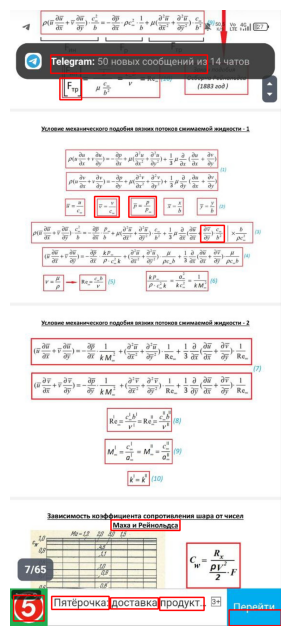


Предсказанные bounding boxes:
1. Класс: BASE (0.77), Координаты: [7.9, 1216.1, 70.3, 1269.4]
2. Класс: BASE (0.73), Координаты: [310.7, 1220.7, 403.0, 1247.1]
3. Класс: BASE (0.69), Координаты: [86.5, 1218.0, 205.1, 1246.0]
4. Класс: BASE (0.63), Координаты: [246.3, 387.0, 303.4, 430.2]
5. Класс: BASE (0.62), Координаты: [175.9, 387.8, 226.9, 430.8]
6. Класс: BASE (0.61), Координаты: [208.4, 1221.3, 307.8, 1244.0]
7. Класс: BASE (0.60), Координаты: [395.7, 447.4, 444.9, 482.8]
8. Класс: BASE (0.59), Координаты: [209.3, 1059.9, 352.5, 1081.8]
9. Класс: BASE (0.58), Координаты: [84.4, 93.7, 409.8, 131.4]
10. Класс: BASE (0.55), Координаты: [103.6, 141.5, 148.8, 186.4]
11. Класс: BASE (0.52), Координаты: [454.1, 1246.5, 562.0, 1279.9]


In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path

def predict_and_visualize(model, image_path, conf_threshold=0.1, iou_threshold=0.1, save_crops=True):
    """
    Предсказывает bounding boxes на изображении, визуализирует результат и сохраняет обрезанные объекты

    Параметры:
        image_path (str): Путь к изображению
        model_path (str): Путь к файлу модели (.pt)
        conf_threshold (float): Порог уверенности (0-1)
        iou_threshold (float): Порог для NMS (0-1)
        save_crops (bool): Сохранять ли обрезанные объекты

    Возвращает:
        list: Список предсказанных bounding boxes в формате [x1, y1, x2, y2, confidence, class_id]
    """
    # Создаем папку для сохранения обрезанных изображений
    if save_crops:
        output_dir = Path("detected")
        output_dir.mkdir(exist_ok=True)

    # Загрузка изображения
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image_rgb.copy()

    # Предсказание
    results = model.predict(
        source=image_rgb,
        conf=conf_threshold,
        iou=iou_threshold,
        save=False,
        show_labels=True,
        show_conf=True
    )

    # Извлечение результатов
    predictions = []
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2]
        confidences = result.boxes.conf.cpu().numpy()
        class_ids = result.boxes.cls.cpu().numpy().astype(int)

        for i, (box, conf, cls_id) in enumerate(zip(boxes, confidences, class_ids)):
            predictions.append([*box, conf, cls_id])

            # Сохранение обрезанного изображения объекта
            if save_crops:
                x1, y1, x2, y2 = map(int, box)
                crop = original_image[y1:y2, x1:x2]

                if crop.size > 0:  # Проверяем, что область не пустая
                    class_name = model.names[cls_id]
                    crop_filename = output_dir / f"{class_name}_{conf:.2f}_{i}.jpg"
                    cv2.imwrite(str(crop_filename), cv2.cvtColor(crop, cv2.COLOR_RGB2BGR))

    # Визуализация
    plt.figure(figsize=(12, 8))
    for box in predictions:
        x1, y1, x2, y2, conf, cls_id = box
        label = f"{model.names[cls_id]} {conf:.2f}"

        # Рисуем прямоугольник
        cv2.rectangle(image_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        # Добавляем текст


    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

    return predictions

# Пример использования
if __name__ == "__main__":
    from ultralytics import YOLO

    # Загрузка модели
    model = YOLO("/content/runs/detect/train3/weights/best.pt")  # или путь к вашей модели

    image_path = "/content/5246767757607957967.jpg"

    # Предсказание и визуализация
    predictions = predict_and_visualize(
        model,
        image_path=image_path,
        conf_threshold=0.5,
        save_crops=True
    )

    # Вывод результатов
    print("\nПредсказанные bounding boxes:")
    for i, pred in enumerate(predictions, 1):
        x1, y1, x2, y2, conf, cls_id = pred
        print(f"{i}. Класс: {model.names[cls_id]} ({conf:.2f}), Координаты: [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}]")

# Распознавание текста



In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests

image = Image.open("/content/detected/BASE_0.76_14.jpg").convert("RGB")

processor = TrOCRProcessor.from_pretrained('kazars24/trocr-base-handwritten-ru')
model = VisionEncoderDecoderModel.from_pretrained('kazars24/trocr-base-handwritten-ru')

pixel_values = processor(images=image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]


generated_text

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

'62 отдечан мичиции'